In [43]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [19]:
def encode_string_to_boolean(df, columns):
    for column in columns:
        df[column] = df[column].map({'Yes': 1, 'No': 0,
                                     'No phone service': 0,
                                     'No internet service': 0})
        df[column] = df[column].fillna(0).astype(np.int64)
    return df

def encode_categorical(df, categorical_columns):
    return pd.get_dummies(df, columns=categorical_columns, drop_first=True)

def scale_data(df):
    scaler = StandardScaler()
    df[df.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(df.select_dtypes(include=[np.number]))
    return df

In [20]:
def round_float64_to_int64(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    if len(float_cols) > 0:
        df[float_cols] = df[float_cols].round()
        df[float_cols] = df[float_cols].fillna(0).astype(np.int64)  # or use another value instead of 0
    return df

In [21]:
TRUE_FALSE_COLUMNS = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Churn']

CATEGORICAL_COLUMNS = ['gender', 'Partner', 'Dependents', 'PhoneService',
                       'MultipleLines', 'InternetService', 'OnlineSecurity',
                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract',
                       'PaperlessBilling', 'PaymentMethod']

DROP_COLUMNS = ['customerID', 'TotalCharges']

## Data clearing & preparation

In [22]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df.drop(columns=DROP_COLUMNS)

In [23]:
df.head()  # Display the first few rows of the DataFrame

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes


In [24]:
df.info()  # Display information about the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [25]:
for column in df.columns:
    if df[column].nunique() < 10:
        print("Column " + column + " values " + str(df[column].unique()))
    else:
        print("Column " + column + " non-categorical") # Display unique values for each column

Column gender values ['Female' 'Male']
Column SeniorCitizen values [0 1]
Column Partner values ['Yes' 'No']
Column Dependents values ['No' 'Yes']
Column tenure non-categorical
Column PhoneService values ['No' 'Yes']
Column MultipleLines values ['No phone service' 'No' 'Yes']
Column InternetService values ['DSL' 'Fiber optic' 'No']
Column OnlineSecurity values ['No' 'Yes' 'No internet service']
Column OnlineBackup values ['Yes' 'No' 'No internet service']
Column DeviceProtection values ['No' 'Yes' 'No internet service']
Column TechSupport values ['No' 'Yes' 'No internet service']
Column StreamingTV values ['No' 'Yes' 'No internet service']
Column StreamingMovies values ['No' 'Yes' 'No internet service']
Column Contract values ['Month-to-month' 'One year' 'Two year']
Column PaperlessBilling values ['Yes' 'No']
Column PaymentMethod values ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Column MonthlyCharges non-categorical
Column Churn values ['N

In [26]:
df = round_float64_to_int64(df)  # Round float64 columns to int64

In [27]:
df['Churn'].value_counts(dropna=False)  # Check for missing values in 'TotalCharges'

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [28]:
for column in TRUE_FALSE_COLUMNS:
    print(df[column].value_counts(dropna=False))  # Check for missing values

Partner
No     3641
Yes    3402
Name: count, dtype: int64
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64
TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64
StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64
StreamingMovies
N

In [29]:
df.columns  # List all columns in the DataFrame

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'Churn'],
      dtype='object')

In [30]:
df_features = encode_string_to_boolean(df, TRUE_FALSE_COLUMNS)

In [31]:
df_features.head()  # Display the first few rows of the DataFrame after encoding

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,30,0
1,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,57,0
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,54,1
3,Male,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42,0
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,71,1


In [32]:
df_features = encode_categorical(df_features, CATEGORICAL_COLUMNS)

In [33]:
bool_cols = df_features.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df_features[bool_cols] = df_features[bool_cols].astype(np.int64)  # or use another value instead of 0

In [34]:
y = df_features['Churn']
X = df_features.drop(columns=['Churn'])
df_scaled = scale_data(X)  # Scale the features

In [41]:
df_scaled.info()  # Display information about the scaled DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   float64
 1   tenure                                 7043 non-null   float64
 2   MonthlyCharges                         7043 non-null   float64
 3   gender_Male                            7043 non-null   float64
 4   Partner_1                              7043 non-null   float64
 5   Dependents_1                           7043 non-null   float64
 6   PhoneService_1                         7043 non-null   float64
 7   MultipleLines_1                        7043 non-null   float64
 8   InternetService_Fiber optic            7043 non-null   float64
 9   InternetService_No                     7043 non-null   float64
 10  OnlineSecurity_1                       7043 non-null   float64
 11  Onli

In [55]:
df_scaled

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_1,Dependents_1,PhoneService_1,MultipleLines_1,InternetService_Fiber optic,InternetService_No,...,DeviceProtection_1,TechSupport_1,StreamingTV_1,StreamingMovies_1,Contract_One year,Contract_Two year,PaperlessBilling_1,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.439916,-1.277445,-1.155179,-1.009559,1.034530,-0.654012,-3.054010,-0.854176,-0.885660,-0.525927,...,-0.723968,-0.639439,-0.790132,-0.796070,-0.514249,-0.562975,0.829798,-0.525047,1.406418,-0.544807
1,-0.439916,0.066327,-0.257856,0.990532,-0.966622,-0.654012,0.327438,-0.854176,-0.885660,-0.525927,...,1.381277,-0.639439,-0.790132,-0.796070,1.944582,-0.562975,-1.205113,-0.525047,-0.711026,1.835513
2,-0.439916,-1.236724,-0.357559,0.990532,-0.966622,-0.654012,0.327438,-0.854176,-0.885660,-0.525927,...,-0.723968,-0.639439,-0.790132,-0.796070,-0.514249,-0.562975,0.829798,-0.525047,-0.711026,1.835513
3,-0.439916,0.514251,-0.756369,0.990532,-0.966622,-0.654012,-3.054010,-0.854176,-0.885660,-0.525927,...,1.381277,1.563872,-0.790132,-0.796070,1.944582,-0.562975,-1.205113,-0.525047,-0.711026,-0.544807
4,-0.439916,-1.236724,0.207422,-1.009559,-0.966622,-0.654012,0.327438,-0.854176,1.129102,-0.525927,...,-0.723968,-0.639439,-0.790132,-0.796070,-0.514249,-0.562975,0.829798,-0.525047,1.406418,-0.544807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.439916,-0.340876,0.672701,0.990532,1.034530,1.529024,0.327438,1.170719,-0.885660,-0.525927,...,1.381277,1.563872,1.265612,1.256171,1.944582,-0.562975,0.829798,-0.525047,-0.711026,1.835513
7039,-0.439916,1.613701,1.270916,-1.009559,1.034530,1.529024,0.327438,1.170719,1.129102,-0.525927,...,1.381277,-0.639439,1.265612,1.256171,1.944582,-0.562975,0.829798,1.904590,-0.711026,-0.544807
7040,-0.439916,-0.870241,-1.155179,-1.009559,1.034530,1.529024,-3.054010,-0.854176,-0.885660,-0.525927,...,-0.723968,-0.639439,-0.790132,-0.796070,-0.514249,-0.562975,0.829798,-0.525047,1.406418,-0.544807
7041,2.273159,-1.155283,0.307125,0.990532,1.034530,-0.654012,0.327438,1.170719,1.129102,-0.525927,...,-0.723968,-0.639439,-0.790132,-0.796070,-0.514249,-0.562975,0.829798,-0.525047,-0.711026,1.835513


In [45]:
# Apply PCA to reduce dimensions from 21 to 3
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)

# Convert back to DataFrame for easy handling
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2', 'PCA3'])
print(df_pca.head())

       PCA1      PCA2      PCA3
0 -1.273431 -1.089000 -2.212645
1 -1.343428  0.604436 -1.840259
2 -1.420045 -0.543213 -1.629219
3 -0.577536  1.466487 -3.969015
4 -0.736387 -2.915849 -0.001991


In [49]:
# Initialize the KMeans algorithm with k clusters
k = 5  # You can start with 3 clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model and assign cluster labels
kmeans.fit(df_pca)
df['Cluster'] = kmeans.labels_

# Display the first few rows with cluster assignments
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,Cluster
0,Female,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,30,0,3
1,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,57,0,0
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,54,1,3
3,Male,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42,0,0
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,71,1,3


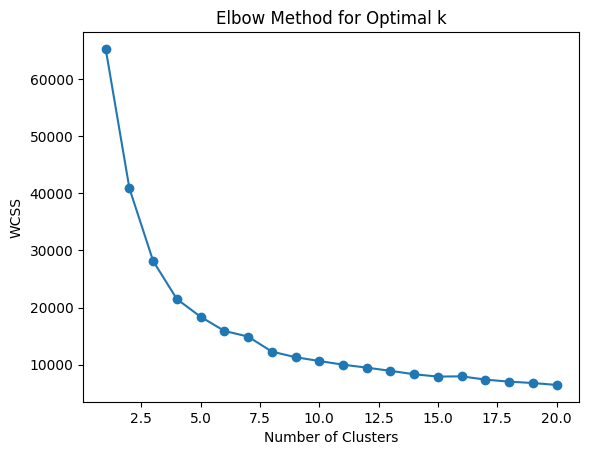

In [48]:
# Calculate the WCSS for different values of k
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to visualize the Elbow
plt.plot(range(1, 21), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

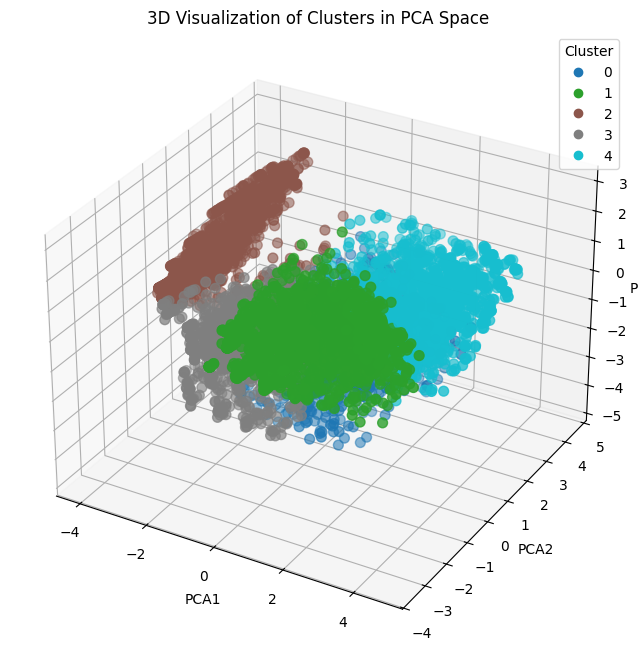

In [50]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'], c=df['Cluster'], cmap='tab10', s=50)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3D Visualization of Clusters in PCA Space')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [51]:
df['Cluster'].value_counts()  # Display the count of customers in each cluster

Cluster
1    1917
2    1530
4    1381
3    1283
0     932
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

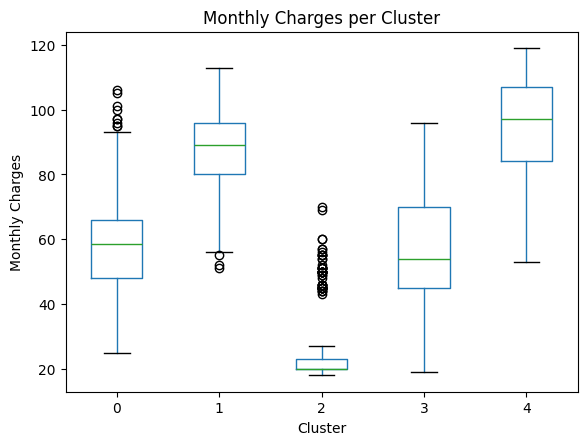

In [52]:
plt.figure(figsize=(10, 6))
df.boxplot(column='MonthlyCharges', by='Cluster', grid=False)
plt.title('Monthly Charges per Cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Monthly Charges')
plt.show()

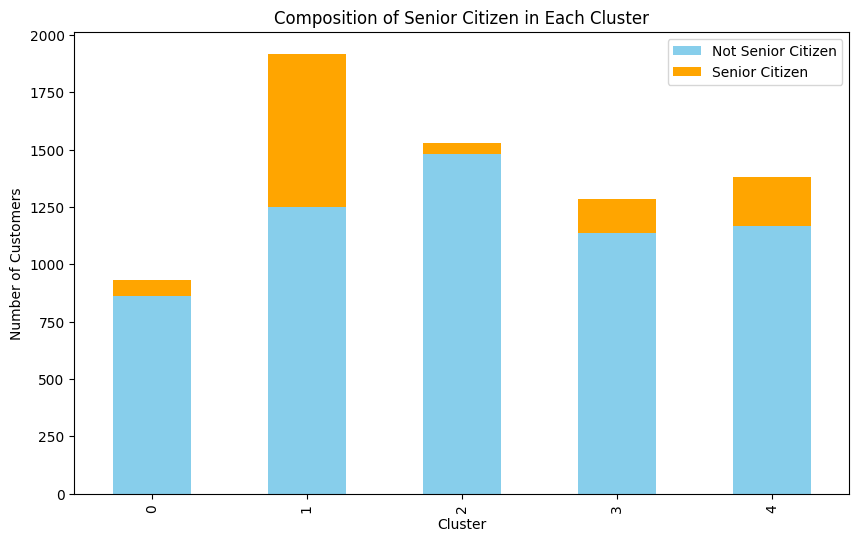

In [54]:
# Stacked bar chart: composition of senior citizens in each cluster
senior_counts = df.groupby(['Cluster', 'SeniorCitizen']).size().unstack(fill_value=0)
senior_counts.plot(kind='bar', stacked=True, figsize=(10,6), color=['skyblue', 'orange'])
plt.title('Composition of Senior Citizen in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend(['Not Senior Citizen', 'Senior Citizen'])
plt.show()

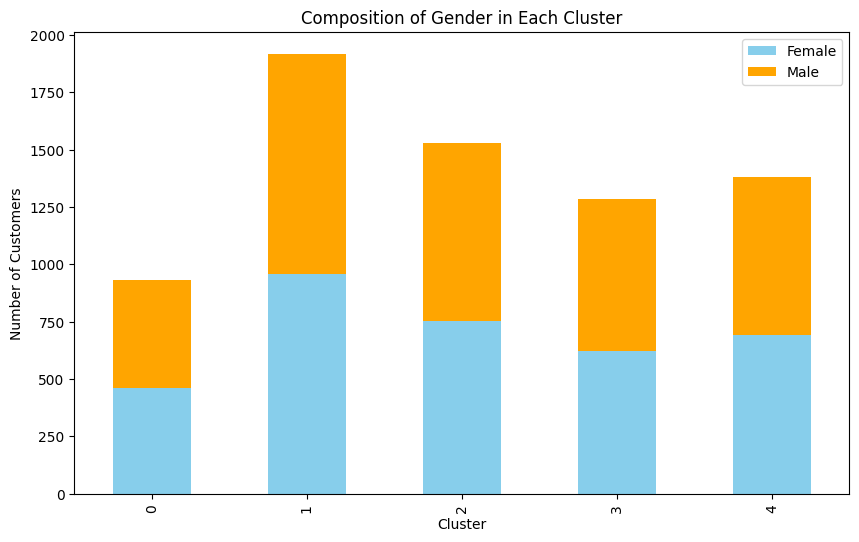

In [56]:
# Stacked bar chart: composition of gender in each cluster
gender_counts = df.groupby(['Cluster', 'gender']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', stacked=True, figsize=(10,6), color=['skyblue', 'orange'])
plt.title('Composition of Gender in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend(['Female', 'Male'])
plt.show()

In [58]:
df.columns  # List all columns in the DataFrame

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'Churn', 'Cluster'],
      dtype='object')

In [66]:
df.InternetService.value_counts(dropna=False)  # Check for missing values in 'Contract'

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

In [62]:
df.groupby(['Cluster', 'Contract']).size().unstack(fill_value=0).columns.to_list()

['Month-to-month', 'One year', 'Two year']

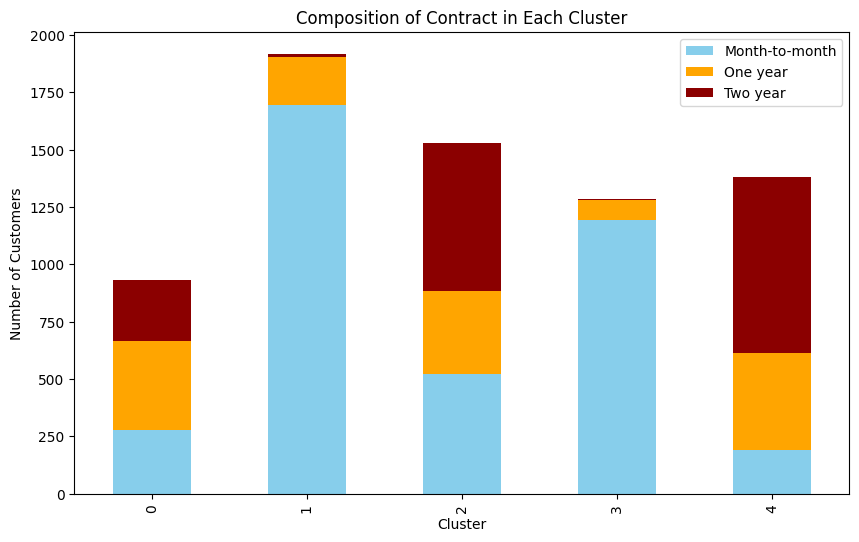

In [65]:
# Stacked bar chart: composition of gender in each cluster
contract = df.groupby(['Cluster', 'Contract']).size().unstack(fill_value=0)
contract.plot(kind='bar', stacked=True, figsize=(10,6), color=['skyblue', 'orange', 'darkred'])
plt.title('Composition of Contract in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend(df.groupby(['Cluster', 'Contract']).size().unstack(fill_value=0).columns.to_list())
plt.show()

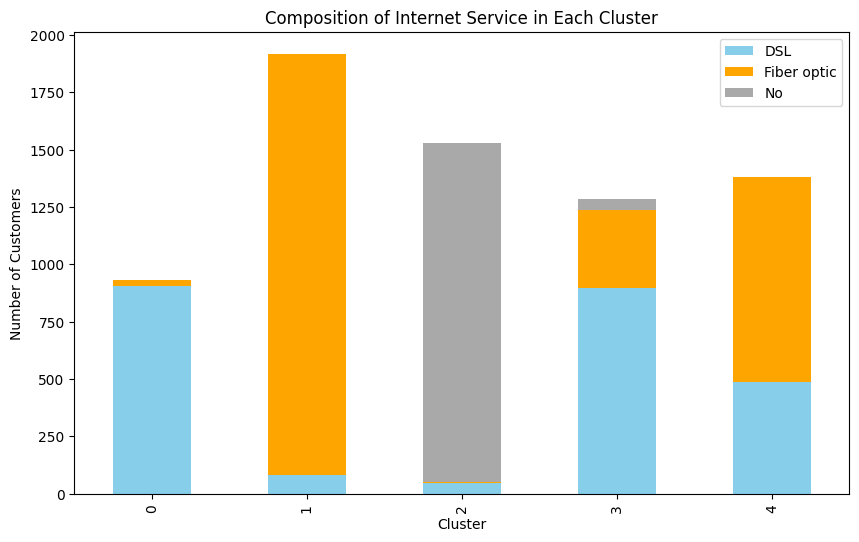

In [67]:
# Stacked bar chart: composition of internet service in each cluster
contract = df.groupby(['Cluster', 'InternetService']).size().unstack(fill_value=0)
contract.plot(kind='bar', stacked=True, figsize=(10,6), color=['skyblue', 'orange', 'darkgrey'])
plt.title('Composition of Internet Service in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend(df.groupby(['Cluster', 'InternetService']).size().unstack(fill_value=0).columns.to_list())
plt.show()

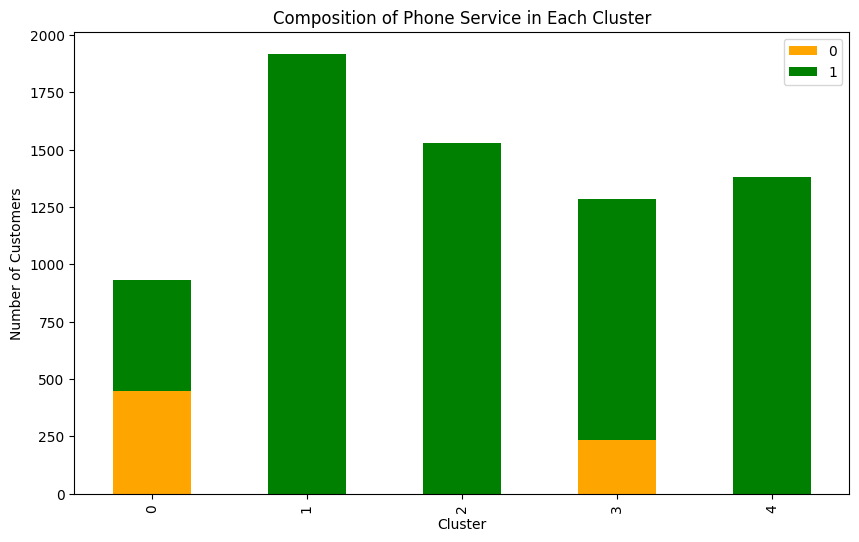

In [73]:
# Stacked bar chart: composition of phone service in each cluster
contract = df.groupby(['Cluster', 'PhoneService']).size().unstack(fill_value=0)
contract.plot(kind='bar', stacked=True, figsize=(10,6), color=['orange', 'green', 'darkgrey'])
plt.title('Composition of Phone Service in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend(df.groupby(['Cluster', 'PhoneService']).size().unstack(fill_value=0).columns.to_list())
plt.show()

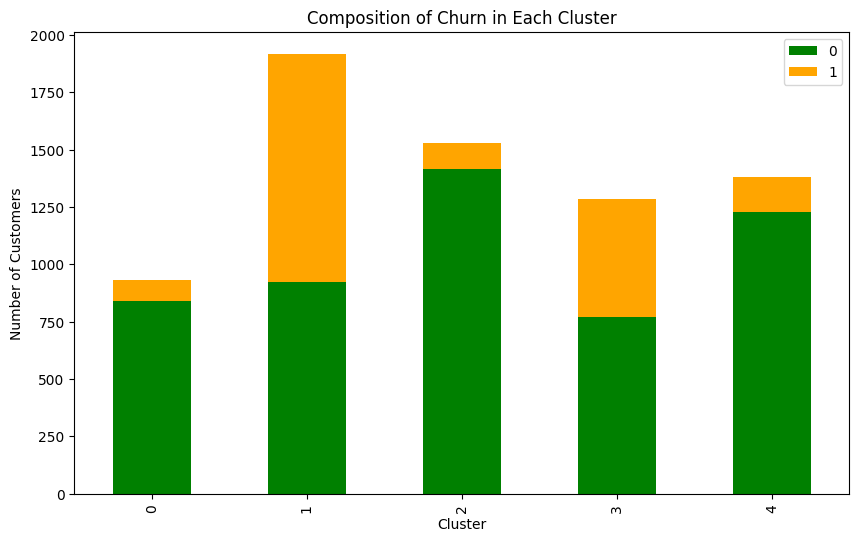

In [75]:
# Stacked bar chart: composition of churn in each cluster
contract = df.groupby(['Cluster', 'Churn']).size().unstack(fill_value=0)
contract.plot(kind='bar', stacked=True, figsize=(10,6), color=['green', 'orange'])
plt.title('Composition of Churn in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.legend(df.groupby(['Cluster', 'Churn']).size().unstack(fill_value=0).columns.to_list())
plt.show()